# Evolver Loop 2 Analysis

## Key Insights from Research

1. **Current Status**: Best score is 70.676102, target is 68.922808 (gap of 1.75 points)
2. **All public solutions converge to same local optimum** - saspav is best for all N
3. **C++ optimizers show 0 improvement** - solutions are already at local optima
4. **Key technique needed**: Lattice-based construction from scratch (egortrushin kernel)

## What the egortrushin kernel does:
- Creates a 2-tree unit cell (one up, one down orientation)
- Tiles this pattern using translation parameters (dx, dy)
- Uses simulated annealing to optimize the translation parameters
- Applies backward propagation to improve smaller N configurations

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

# Load the best solution
df = pd.read_csv('/home/code/santa-2025-csv/santa-2025.csv')
print(f"Loaded {len(df)} rows")

# Parse values
def parse_value(s):
    if isinstance(s, str) and s.startswith('s'):
        return float(s[1:])
    return float(s)

df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))
df['x_val'] = df['x'].apply(parse_value)
df['y_val'] = df['y'].apply(parse_value)
df['deg_val'] = df['deg'].apply(parse_value)

Loaded 20100 rows


In [2]:
# Analyze the score contribution by N
def get_tree_vertices():
    trunk_w = 0.15
    trunk_h = 0.2
    base_w = 0.7
    mid_w = 0.4
    top_w = 0.25
    tip_y = 0.8
    tier_1_y = 0.5
    tier_2_y = 0.25
    base_y = 0.0
    trunk_bottom_y = -trunk_h
    
    vertices = [
        (0.0, tip_y),
        (top_w / 2, tier_1_y),
        (top_w / 4, tier_1_y),
        (mid_w / 2, tier_2_y),
        (mid_w / 4, tier_2_y),
        (base_w / 2, base_y),
        (trunk_w / 2, base_y),
        (trunk_w / 2, trunk_bottom_y),
        (-trunk_w / 2, trunk_bottom_y),
        (-trunk_w / 2, base_y),
        (-base_w / 2, base_y),
        (-mid_w / 4, tier_2_y),
        (-mid_w / 2, tier_2_y),
        (-top_w / 4, tier_1_y),
        (-top_w / 2, tier_1_y),
    ]
    return vertices

BASE_TREE = Polygon(get_tree_vertices())

def create_tree_polygon(x, y, deg):
    tree = rotate(BASE_TREE, deg, origin=(0, 0))
    tree = translate(tree, x, y)
    return tree

def get_bounding_box_side(trees_df):
    all_x = []
    all_y = []
    for _, row in trees_df.iterrows():
        poly = create_tree_polygon(row['x_val'], row['y_val'], row['deg_val'])
        minx, miny, maxx, maxy = poly.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    width = max(all_x) - min(all_x)
    height = max(all_y) - min(all_y)
    return max(width, height)

In [3]:
# Calculate score contribution for each N
scores_by_n = []
for n in range(1, 201):
    trees_n = df[df['n'] == n]
    side = get_bounding_box_side(trees_n)
    score_n = side ** 2 / n
    scores_by_n.append({'n': n, 'side': side, 'score': score_n})

scores_df = pd.DataFrame(scores_by_n)
print(f"Total score: {scores_df['score'].sum():.6f}")
print(f"\nTop 10 highest score contributions:")
print(scores_df.nlargest(10, 'score')[['n', 'side', 'score']])

Total score: 70.676102

Top 10 highest score contributions:
     n      side     score
0    1  0.813173  0.661250
1    2  0.949504  0.450779
2    3  1.142031  0.434745
4    5  1.443692  0.416850
3    4  1.290806  0.416545
6    7  1.673104  0.399897
5    6  1.548438  0.399610
8    9  1.867280  0.387415
7    8  1.755921  0.385407
14  15  2.384962  0.379203


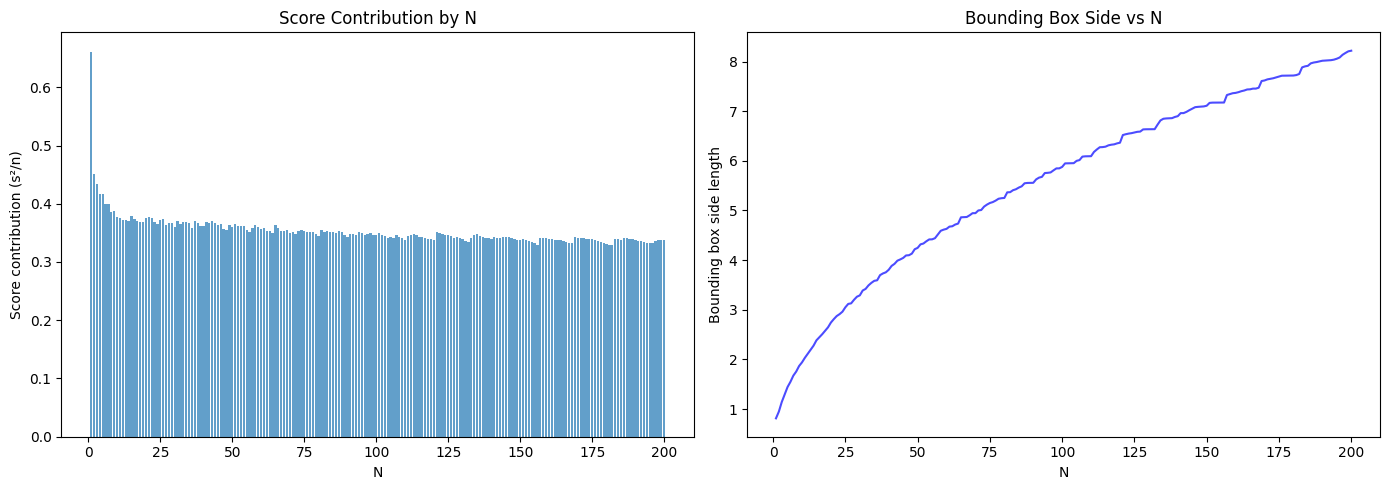

In [4]:
# Plot score contribution by N
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(scores_df['n'], scores_df['score'], alpha=0.7)
axes[0].set_xlabel('N')
axes[0].set_ylabel('Score contribution (s²/n)')
axes[0].set_title('Score Contribution by N')

axes[1].plot(scores_df['n'], scores_df['side'], 'b-', alpha=0.7)
axes[1].set_xlabel('N')
axes[1].set_ylabel('Bounding box side length')
axes[1].set_title('Bounding Box Side vs N')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_by_n.png', dpi=100)
plt.show()

In [5]:
# Analyze which N values have the most room for improvement
# Theoretical minimum: if trees packed perfectly, side ~ sqrt(n * tree_area)
tree_area = BASE_TREE.area
print(f"Single tree area: {tree_area:.6f}")
print(f"Single tree bounds: {BASE_TREE.bounds}")

# Calculate efficiency (how close to theoretical minimum)
scores_df['theoretical_min_side'] = np.sqrt(scores_df['n'] * tree_area)
scores_df['efficiency'] = scores_df['theoretical_min_side'] / scores_df['side']

print(f"\nLowest efficiency N values (most room for improvement):")
print(scores_df.nsmallest(10, 'efficiency')[['n', 'side', 'theoretical_min_side', 'efficiency', 'score']])

Single tree area: 0.245625
Single tree bounds: (-0.35, -0.2, 0.35, 0.8)

Lowest efficiency N values (most room for improvement):
     n      side  theoretical_min_side  efficiency     score
0    1  0.813173              0.495606    0.609472  0.661250
1    2  0.949504              0.700892    0.738167  0.450779
2    3  1.142031              0.858414    0.751656  0.434745
4    5  1.443692              1.108208    0.767621  0.416850
3    4  1.290806              0.991211    0.767901  0.416545
6    7  1.673104              1.311249    0.783723  0.399897
5    6  1.548438              1.213981    0.784003  0.399610
8    9  1.867280              1.486817    0.796247  0.387415
7    8  1.755921              1.401785    0.798319  0.385407
14  15  2.384962              1.919473    0.804823  0.379203


In [6]:
# Analyze the lattice pattern in the best solution for large N
# Look at N=200 to understand the packing structure
n = 200
trees_200 = df[df['n'] == n].copy()

# Classify trees by orientation (up vs down)
trees_200['is_up'] = trees_200['deg_val'].apply(lambda d: abs(d % 360) < 90 or abs(d % 360) > 270)

print(f"N=200 analysis:")
print(f"  Trees pointing up: {trees_200['is_up'].sum()}")
print(f"  Trees pointing down: {(~trees_200['is_up']).sum()}")

# Calculate centroid
cx = trees_200['x_val'].mean()
cy = trees_200['y_val'].mean()
print(f"  Centroid: ({cx:.4f}, {cy:.4f})")

# Look at spacing between trees
from scipy.spatial.distance import cdist
coords = trees_200[['x_val', 'y_val']].values
dists = cdist(coords, coords)
np.fill_diagonal(dists, np.inf)
min_dists = dists.min(axis=1)
print(f"  Min distance between trees: {min_dists.min():.4f}")
print(f"  Mean min distance: {min_dists.mean():.4f}")
print(f"  Std min distance: {min_dists.std():.4f}")

N=200 analysis:
  Trees pointing up: 101
  Trees pointing down: 99
  Centroid: (-0.0194, -0.3506)
  Min distance between trees: 0.2500
  Mean min distance: 0.3150
  Std min distance: 0.1288


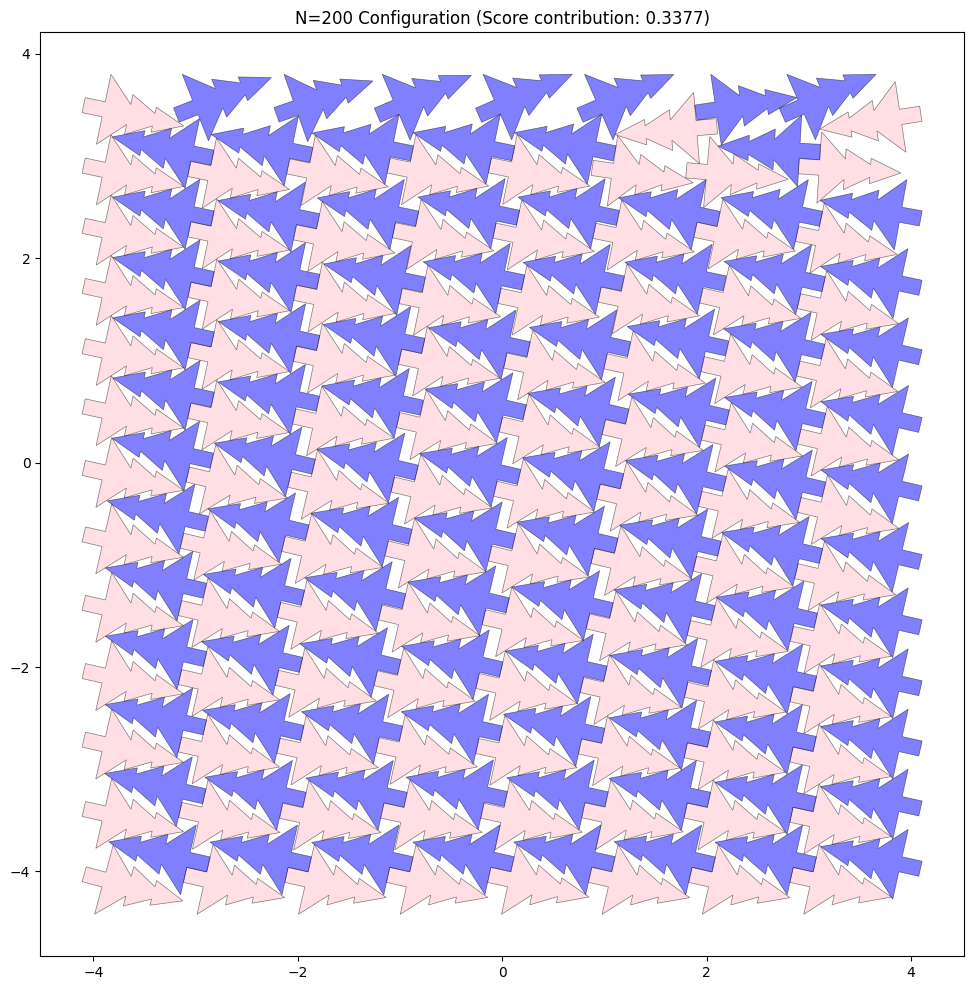

In [7]:
# Visualize the N=200 configuration
fig, ax = plt.subplots(figsize=(12, 12))

for _, row in trees_200.iterrows():
    poly = create_tree_polygon(row['x_val'], row['y_val'], row['deg_val'])
    color = 'blue' if row['is_up'] else 'pink'
    x, y = poly.exterior.xy
    ax.fill(x, y, alpha=0.5, fc=color, ec='black', linewidth=0.5)

ax.set_aspect('equal')
ax.set_title(f'N=200 Configuration (Score contribution: {scores_df[scores_df["n"]==200]["score"].values[0]:.4f})')
plt.savefig('/home/code/exploration/n200_config.png', dpi=100)
plt.show()

In [8]:
# Key insight: To improve, we need to try different lattice patterns
# The egortrushin approach uses a 2-tree unit cell with SA on translation parameters

# Let's understand what translation parameters might work
# For a 2-tree unit cell, we need:
# - Tree 1 at (0, 0) with angle 0 (pointing up)
# - Tree 2 at (dx, dy) with angle 180 (pointing down)
# Then tile this pattern

# The key is finding optimal (dx, dy) for the unit cell
# Let's analyze the current solution to extract these parameters

# Find pairs of adjacent up/down trees
up_trees = trees_200[trees_200['is_up']]
down_trees = trees_200[~trees_200['is_up']]

print(f"Analyzing up-down pairs in N=200:")

# For each up tree, find nearest down tree
offsets = []
for _, up in up_trees.iterrows():
    dists = np.sqrt((down_trees['x_val'] - up['x_val'])**2 + (down_trees['y_val'] - up['y_val'])**2)
    nearest_idx = dists.idxmin()
    nearest_down = down_trees.loc[nearest_idx]
    dx = nearest_down['x_val'] - up['x_val']
    dy = nearest_down['y_val'] - up['y_val']
    offsets.append({'dx': dx, 'dy': dy, 'dist': dists.min()})

offsets_df = pd.DataFrame(offsets)
print(f"\nOffset statistics (up -> nearest down):")
print(f"  dx: mean={offsets_df['dx'].mean():.4f}, std={offsets_df['dx'].std():.4f}")
print(f"  dy: mean={offsets_df['dy'].mean():.4f}, std={offsets_df['dy'].std():.4f}")
print(f"  dist: mean={offsets_df['dist'].mean():.4f}, std={offsets_df['dist'].std():.4f}")

Analyzing up-down pairs in N=200:

Offset statistics (up -> nearest down):
  dx: mean=0.0463, std=0.3119
  dy: mean=-0.2285, std=0.1005
  dist: mean=0.3487, std=0.1986


In [9]:
# Summary of findings
print("="*60)
print("SUMMARY OF FINDINGS")
print("="*60)
print(f"\n1. Current best score: {scores_df['score'].sum():.6f}")
print(f"   Target score: 68.922808")
print(f"   Gap: {scores_df['score'].sum() - 68.922808:.6f}")

print(f"\n2. Score contribution breakdown:")
print(f"   Small N (1-50): {scores_df[scores_df['n'] <= 50]['score'].sum():.4f}")
print(f"   Medium N (51-100): {scores_df[(scores_df['n'] > 50) & (scores_df['n'] <= 100)]['score'].sum():.4f}")
print(f"   Large N (101-200): {scores_df[scores_df['n'] > 100]['score'].sum():.4f}")

print(f"\n3. Key insight: All public solutions converge to same local optimum")
print(f"   - C++ optimizers show 0 improvement")
print(f"   - Ensembling provides 0 improvement")
print(f"   - Need fundamentally different approach")

print(f"\n4. Recommended approach: Lattice-based construction")
print(f"   - Create 2-tree unit cell (up + down orientation)")
print(f"   - Optimize translation parameters with SA")
print(f"   - Apply backward propagation")
print(f"   - Focus on large N where efficiency is lowest")

SUMMARY OF FINDINGS

1. Current best score: 70.676102
   Target score: 68.922808
   Gap: 1.753294

2. Score contribution breakdown:
   Small N (1-50): 19.0422
   Medium N (51-100): 17.6411
   Large N (101-200): 33.9928

3. Key insight: All public solutions converge to same local optimum
   - C++ optimizers show 0 improvement
   - Ensembling provides 0 improvement
   - Need fundamentally different approach

4. Recommended approach: Lattice-based construction
   - Create 2-tree unit cell (up + down orientation)
   - Optimize translation parameters with SA
   - Apply backward propagation
   - Focus on large N where efficiency is lowest
